In [1]:
import torch 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import collections
import os
import sys
import random

sys.path.append(r'C:/Users/yankong/Documents/GNN without link capacity/routnet/model')
sys.path.append(r'C:/Users/yankong/Documents/GNN without link capacity/routnet/data_loader')
sys.path.append(r'C:/Users/yankong/Documents/GNN without link capacity/routnet')

import base
import model
import utils
import data_loaders
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
## initialize the network, and load the model you want to test
GNN = model.GraphNeuralNet(32, 32, 256, 256, 1, 0.5, 8, 10)
GNN.load_state_dict(torch.load(r"C:\Users\yankong\Documents\best2.pth", map_location=torch.device('cpu')))
GNN.to(device)
GNN.train()

GraphNeuralNet(
  (edge_update): GRU(32, 32, batch_first=True)
  (path_update): GRU(32, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [4]:
## load the transform used by the model
transform = {"type": "original", "mean_TM": 0.5,"std_TM":0.5,
             "mean_delay":2.8,"std_delay":2.5, "scale_drops":12000,"bias_drops":0.5}

In [52]:
## create the data_loader
random.seed(13)
dataset_dir = r"C:\Users\yankong\Downloads\nsfnet"
netDataset = data_loaders.NetDataset(dataset_dir, ["delay"], transform)

In [ ]:
## create the data_loader
dataset_dir = r"C:\Users\yankong\Downloads\geant2"
netDataset_geant2 = data_loaders.NetDataset(dataset_dir, ["delay"], transform)

In [5]:
## create the data_loader
dataset_dir = r"C:\Users\yankong\Downloads\GBN"
netDataset_GBN = data_loaders.NetDataset(dataset_dir, ["delay"], transform)

In [7]:
## generate samples from the dataloder
import math
num_samples = 40
samples = []
selected_dataset = netDataset_GBN ## change the dataset you want to validate
selected_samples = np.random.choice([i for i in range(len(selected_dataset))], num_samples)
for sample in selected_samples:
    data, target = selected_dataset[sample]
    samples.append((data, target))
sample_inputs, sample_targets = utils.collate_fn(samples)
data = sample_inputs
target = sample_targets
data_list = []
data_len = len(data)
for i in range(data_len):
    if type(data[i]) == torch.Tensor:
        data_list.append(data[i].to(device))
    else:
        data_list.append([datum.to(device) for datum in data[i]])
data = tuple(data_list)
target = target.to(device)

C:/Users/yankong/Documents/GNN without link capacity/routnet\utils\util.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_sequ_indices = torch.tensor(list_sequ_indices, dtype=torch.long)


In [8]:
## get the prediction of the samples
num_iter = 50
predictions = []
with torch.no_grad():
    for _ in range(num_iter):
        prediction = GNN(data)
        predictions.append(prediction.cpu().numpy())

In [9]:
predictions_matrix = np.stack(predictions, axis=0).squeeze()
prediction = np.mean(predictions_matrix, axis=0)
target = target.cpu().numpy().squeeze()
prediction = prediction*transform["std_delay"] + transform["mean_delay"]
target = target*transform["std_delay"] + transform["mean_delay"]

In [10]:
prediction= np.median(predictions_matrix, axis=0)
prediction = prediction*transform["std_delay"] + transform["mean_delay"]

In [16]:
prediction = np.mean(predictions_matrix, axis=0)
prediction = prediction*transform["std_delay"] + transform["mean_delay"]

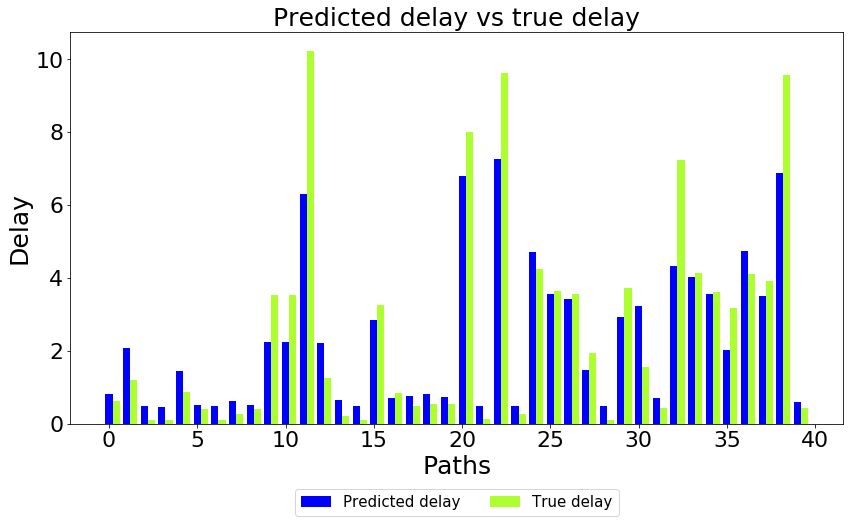

In [18]:
# create plot
num_paths = 40
indices = np.random.choice([i for i in range(prediction.shape[0])], num_paths)
fig, ax = plt.subplots()
index = np.arange(num_paths)
bar_width = 0.40

rects1 = plt.bar(index, prediction[indices], bar_width,
color='b',
label='Predicted delay')

rects2 = plt.bar(index + bar_width, target[indices], bar_width,
color='greenyellow',
label='True delay')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)

plt.xlabel('Paths',fontsize=25)
plt.ylabel('Delay',fontsize=25)
plt.title('Predicted delay vs true delay',fontsize=25)
plt.legend(loc='center',fontsize=15,bbox_to_anchor=(0.5, -0.20),fancybox=True,ncol=2)
plt.tight_layout()

fig = plt.gcf()
fig.set_size_inches(14, 8.5)

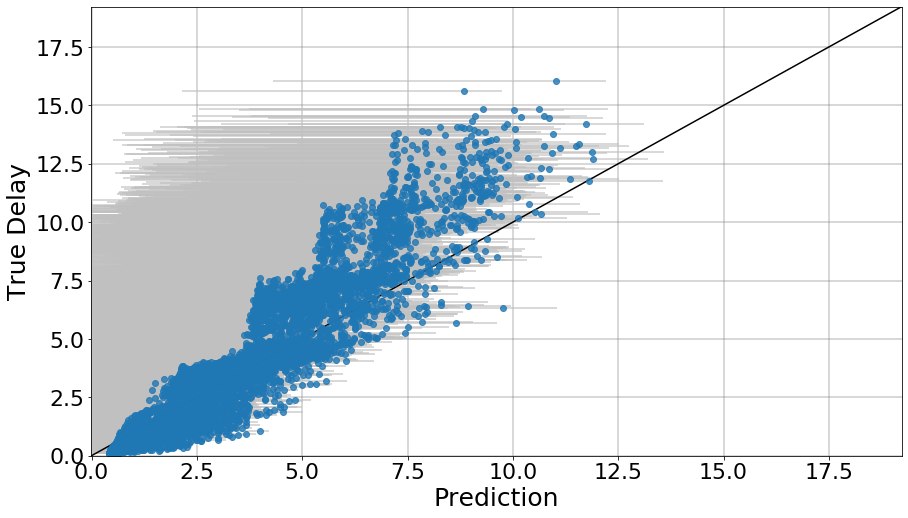

In [20]:
ax = plt.subplot()
num_paths = 100
indices = np.random.choice([i for i in range(prediction.shape[0])], num_paths)


xerr = [prediction - np.percentile(predictions_matrix, q=5, axis=0)*transform["std_delay"] + transform["mean_delay"],
        np.percentile(predictions_matrix, q=95, axis=0)*transform["std_delay"] + transform["mean_delay"] - prediction]

ax.errorbar(x=prediction, y=target, fmt='o', xerr=xerr, alpha=0.8, ecolor='silver')

m = max(target)
ax.plot([0, 1.3 * m], [0, 1.3 * m], 'k')
ax.grid(color='gray', linestyle='-', linewidth=2, alpha=0.3)
ax.set_xlabel('Prediction', fontsize=25)
ax.set_ylabel('True Delay', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
ax.set_xlim(left=-0.002, right=1.2 * m)
ax.set_ylim(bottom=-0.005, top=1.2 * m)
fig = plt.gcf()
plt.tight_layout()
fig.set_size_inches(14, 8.5)

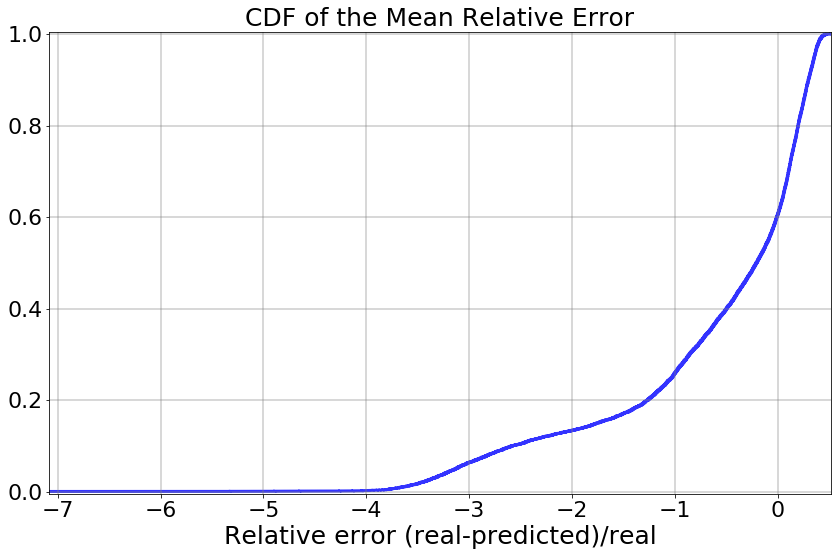

In [19]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

mre = (target-prediction)/target
mre = np.sort(mre)

mre = np.insert(mre, 0, -15.0)
mre = np.append(mre, 15.0)

plt.hist(mre, cumulative=True, histtype='step', bins=10000, alpha=0.8, color='blue', density=True, linewidth=3)
plt.ylim((-0.005, 1.005))
plt.xlim((mre[1], mre[-2]))
plt.xlabel("Relative error (real-predicted)/real", fontsize=25)
plt.rc('xtick',labelsize=22)
plt.rc('ytick',labelsize=22)
plt.grid(color='gray', linestyle='-', linewidth=2, alpha=0.3)
plt.title('CDF of the Mean Relative Error',fontsize=25)
fig = plt.gcf()
fig.set_size_inches(14, 8.5)